In [10]:
import healpy as hp
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import time
from scipy import linalg
import scipy.sparse as sp

matplotlib.rcParams['figure.figsize'] = (7.5,7.5)
path = '/home/sambit/Downloads/PyStoch-master/src/'

tolerance = 1e-8
iterations = 100
inj_flag = 0

# change 'inj_flag' value to toggle use between injection source and actual source!  

## Important Functions

__NMSE:__
Normalized Mean Squared Error: 
$ \textsf{NMSE}(\vec{a},\vec{b}) = \frac{|\vec{a} - \vec{b}|^2}{\vec{a}\cdot\vec{b}} $


__NSP:__
Normalized Scalar Product: 
$ \textsf{NSP}(\vec{a},\vec{b}) = \frac{\vec{a}\cdot\vec{b}}{\sqrt{|\vec{a}|^{2}|\vec{b}|^2}} $


__Deconvolution:__
Function carries out the deconvolution process using the CGS method of the linalg module from scipy library.


__normHess:__
Function returns the Hessian matrix calculated for a norm regularization function:
* Regularization Function: $R(S) = \frac{1}{2}\sum_{i = 0}^{i = n_{pix}} S_{i}^2$
* Hessian: $H_{ij} = \delta_{ij}$


__quadHess:__
Function returns the Hessain matrix for a quadratic regularization function:
* Regularization Function: $ R(S) = \frac{1}{2}\sum_{i = 0}^{i = n_{pix}} \sum_{j_{i}} (S_i - S_{j_i})^2$, where $j_{i}$ are the neighbouring pixels of pixel 'i'
* Hessian: $H_{ij} = 2N_{\eta_{i}} \delta_{ij} - 2 \delta_{\eta_{i}j}$, where $\eta_i$ is the neighbouring pixels of $i^{th}$ pixel and $N_{\eta_i}$ is the number of neighbouring pixels 

In [11]:
# Normalised Mean Squared Error (NMSE)
def NMSE(arr, map_inj):
    return ((arr-map_inj).dot(arr-map_inj)/(map_inj.dot(map_inj)))

# Normalised Scalar Product
def NSP(clean_map, source_map):
    return (source_map.dot(clean_map)/np.sqrt(source_map.dot(source_map)*clean_map.dot(clean_map)))

In [12]:
# Function to solve deconvolution equation using CGS method from scipy library.    
def deconvolution(map_dirty, fisher, reg_strength, hessian):
    
    clean_map = sp.linalg.cgs(np.real(fisher) + reg_strength * hessian, np.squeeze(map_dirty),
                              tol = tolerance, maxiter = iterations)   
    return clean_map

In [14]:
# Function to create the Norm Hessian Matrix:
def normHess(npix):
    return np.eye(npix)

# Function to create the Quadratic Hessian Matrix:
def quadHess(npix):
    nside = hp.npix2nside(npix)
    nbrs = []
    for i in range(npix):
        nbrs.append(hp.get_all_neighbours(nside, hp.pix2ang(nside, i)[0], hp.pix2ang(nside, i)[1]))

    nbrs_len = np.array([len(nbr_row) for nbr_row in nbrs]).reshape(-1, 1)
    H = (np.eye(npix) * 2) * nbrs_len

    for i in range(npix):
        for j in nbrs[i]:
            H[i, j] -= 2
    
    return H

## Import Files

Import files from NPY_files folder in src:
__Broadband npy files in this folder are already processed from [Save_Fisher.ipynb](./Save_Fisher.ipynb).__

The following files are available:
- Fisher Information Matrix
- Dirty Map from injection (which might not be required at this point)
- Dirty Map from LIGO S5 data
- Simulated Noise Map from the calculated Fisher Information: _For new noise realisations, run Save_Fisher.ipynb again._

In [15]:
# Dirty Map:
dirty_map = np.squeeze(np.load(path + 'NPY_files/Dirty_Map_40_1800Hz.npy', allow_pickle = True))
            
# Fisher Matrix:
fisher = np.load(path + 'NPY_files/Fisher_40_1800Hz.npy', allow_pickle = True)

# Noise Map:
noise = np.load(path + 'NPY_files/Noise_map.npy', allow_pickle = True)

# Pre Computed Beam Matrix:
# B = np.loadtxt(path + 'NPY_files/beam3072.dat')

# Dirty Map Injected Import:
# map_dirty_inj = np.squeeze(np.load(path + 'NPY_files/Dirty_Map_inj_40_1800Hz_s=1e-49.npy', allow_pickle = True))

# # Diagonal Fisher matrix Import:
# diag_fisher = np.load('NPY_files/Fisher_Diag_WB.npy', allow_pickle = True)

#### __Hessian Matrix:__

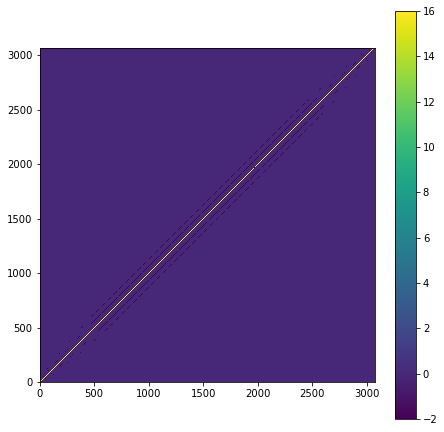

In [16]:
# Hessian Matrix:
H = quadHess(np.size(dirty_map))
plt.imshow(H, origin = 'lower')
plt.colorbar()
plt.show()

#### __Mean and Variance of Noise maps:__
- Noise Maps required for injection maps.
- To display Noise Map Gaussianity, histogram is plotted which should closely match the zero mean normal distribution.
- For another noise map, run [Save_Fisher.ipynb](./Save_Fisher.ipynb)

Mean = -1.9013495130331496e+48
Variance = 5.13162511474022e+49


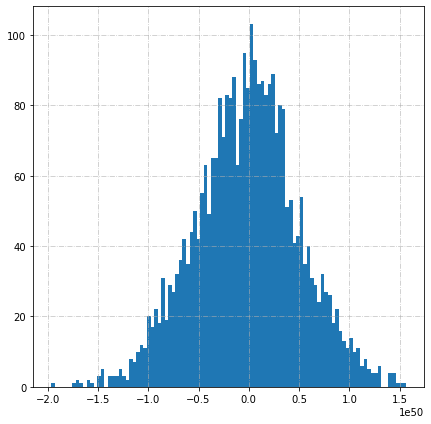

In [17]:
mu = np.mean(np.squeeze(noise))
sigma = np.std(np.squeeze(noise))
print('Mean = {}\nVariance = {}'.format(mu, sigma))

plt.figure(figsize = (7,7))
plt.hist(noise, bins = 100)
plt.grid(linestyle = '-.', alpha = 0.7)
plt.show()

#### __Injected Map__:

Injected dirty map is created by following the convolution equation of:

$\Gamma\cdot source\_map + noise = dirty\_map$

where the $source\_map$ is the injected source map.

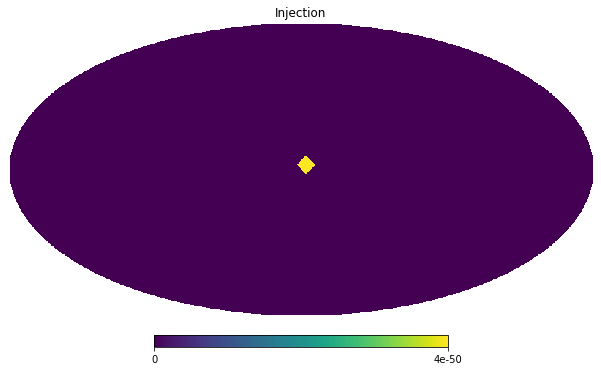

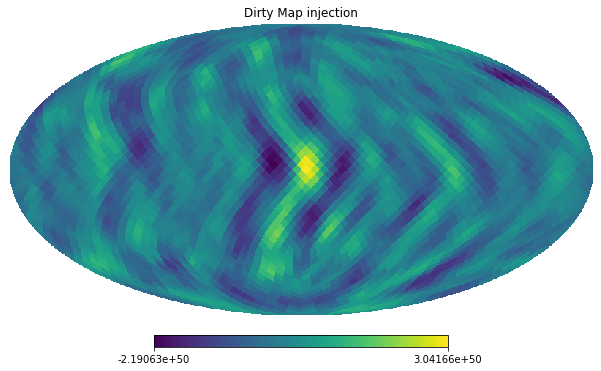

In [18]:
# Injected Source Map:
inj = np.zeros((3072,))
s = 4e-50                                # strength

inj[hp.ang2pix(16, np.pi/2, 0)] = s
neighbours = hp.get_all_neighbours(16, np.pi/2, 0)
inj[neighbours[0]] = s
inj[neighbours[1]] = s
inj[neighbours[2]] = s

dirty_map_inj = np.real(fisher).dot(inj) + noise

hp.mollview(inj, title = 'Injection')
hp.mollview(dirty_map_inj, title = 'Dirty Map injection')

#### __Display Fisher Matrix and Hessian:__

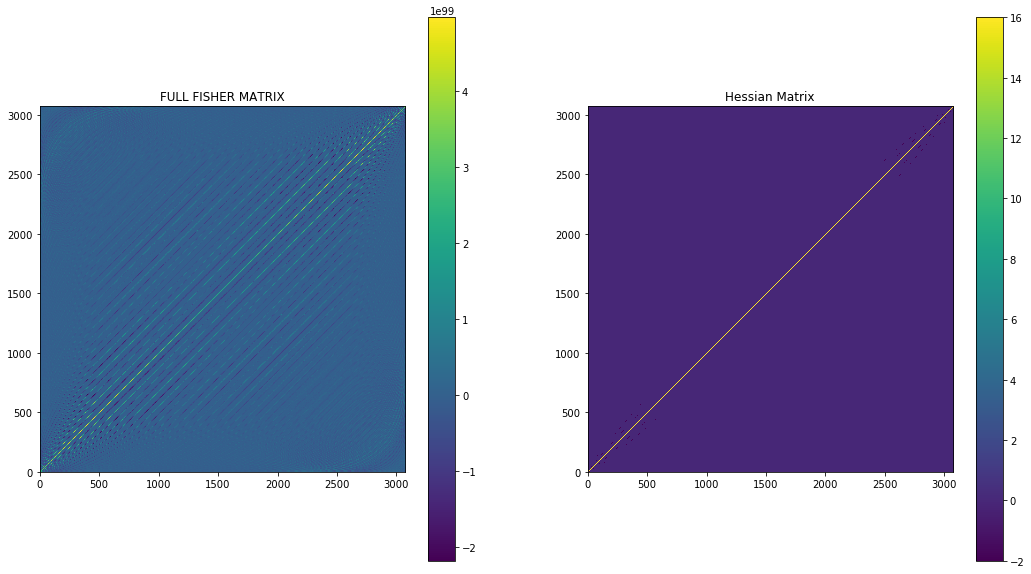

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (15*5//4,10))

im = ax[0].imshow(np.real(fisher), origin = 'lower')
fig.colorbar(im, ax = ax[0])
ax[0].set_title('FULL FISHER MATRIX')

im = ax[1].imshow(H, origin = 'lower')
fig.colorbar(im, ax = ax[1])
ax[1].set_title('Hessian Matrix')
plt.show()

Looking at the difference in order of magnitude between element values of Fisher Information Matrix and Hessian, the need of normalising Fisher matrix is clear.

#### __SNR Map__

/home/sambit/anaconda3/lib/python3.7/site-packages/healpy/projector.py:201: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


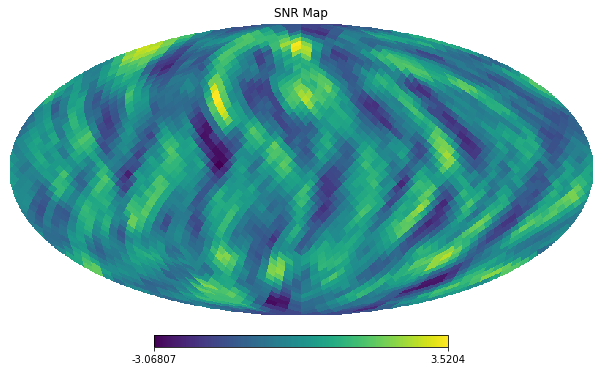

In [23]:
fisher_diag = np.diagonal(np.real(fisher))
snr = np.divide(dirty_map, np.sqrt(fisher_diag)) * 4

hp.mollview(snr, title = 'SNR Map')

***

`'map_dirty'` variable is used for all analysis from this point which can be set to one of the following two:
- `dirty_map_inj` _(Dirty Map from the injection source)_: For deconvolving the injection map
- `dirty_map` _(Dirty Map of the LIGO Data)_: For deconvolving the data map

In [24]:
if inj_flag:
    map_dirty = dirty_map_inj
else:
    map_dirty = dirty_map

## Normalization

__Scheme used:__

$\bar{\Gamma} = \Gamma.\left[\frac{\textbf{H}_{max} - \textbf{H}_{min}}{\Gamma_{max} - \Gamma_{min}}\right]$ and
$\bar{\textbf{X}} = \textbf{X}.\left[\frac{\textbf{H}_{max} - \textbf{H}_{min}}{\textbf{X}_{max} - \textbf{X}_{min}}\right]$

In [25]:
def normalise(arr):
    norm_const = (np.max(H) - np.min(H))/(np.max(arr) - np.min(arr))
    norm_arr = arr * norm_const
    
    return norm_arr

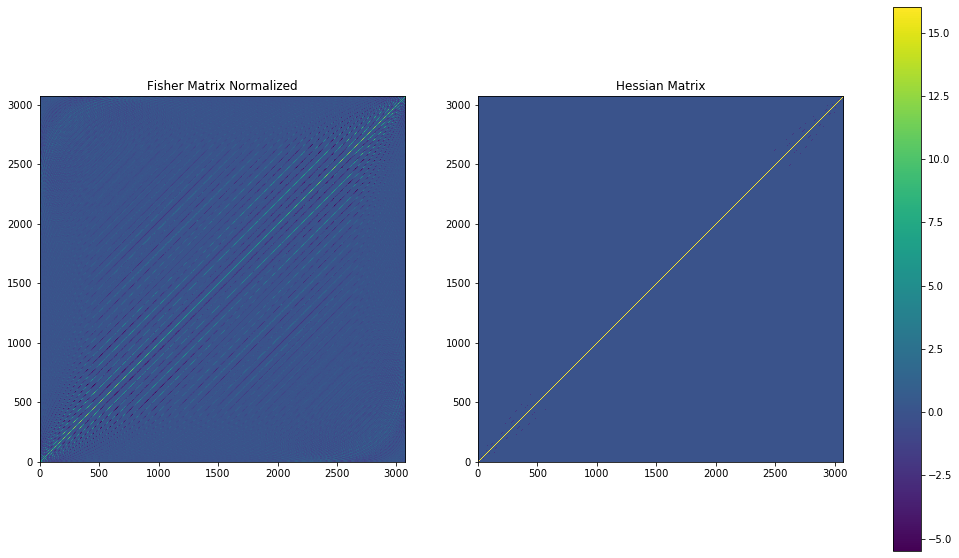

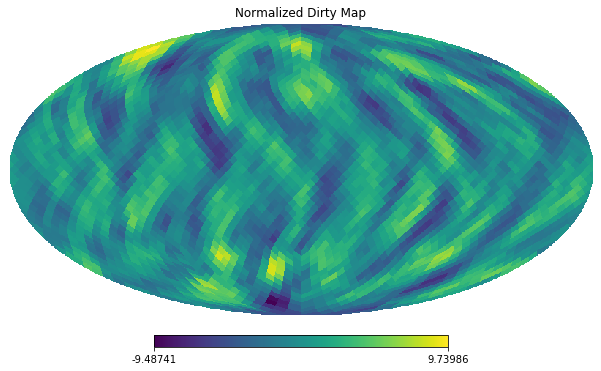

In [26]:
fisher_n = normalise(np.real(fisher))
map_dirty_n = normalise(map_dirty)

fig, axs = plt.subplots(1, 2, figsize = (15*5//4, 10))
vmin = np.min([np.min(fisher_n), np.min(H)])
vmax = np.max([np.max(fisher_n), np.max(H)])

im = axs[0].imshow(np.real(fisher_n), origin = 'lower', vmin = vmin, vmax = vmax)
axs[0].set_title('Fisher Matrix Normalized')

im = axs[1].imshow(H, origin = 'lower', vmin = vmin, vmax = vmax)
axs[1].set_title('Hessian Matrix')

fig.colorbar(im, ax = axs.ravel().tolist())
plt.show()

hp.mollview(np.squeeze(map_dirty_n), title = 'Normalized Dirty Map')

#### __SNR Map after normalisation__

snr == snr_n: True


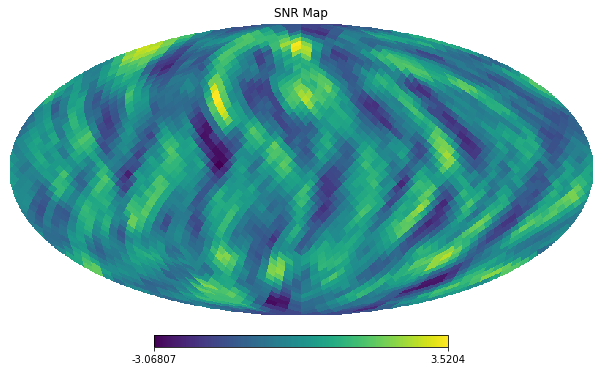

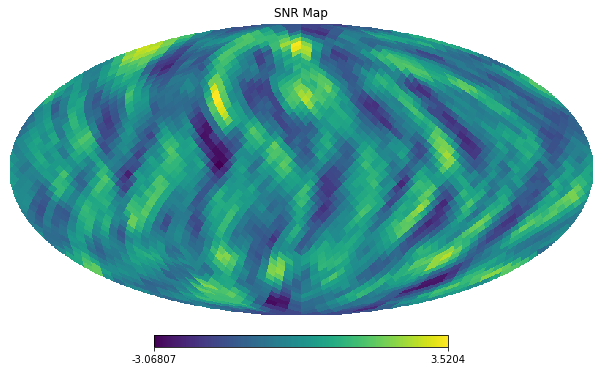

In [27]:
fisher_diag_n = np.diagonal(np.real(fisher_n))
f = np.sqrt((np.max(np.real(fisher)) - np.min(np.real(fisher))) * (np.max(H) - np.min(H))) / (np.max(map_dirty) - np.min(map_dirty))

snr_n = np.divide(map_dirty_n, np.sqrt(fisher_diag_n)) * (4/f)

hp.mollview(snr, title = 'SNR Map')
hp.mollview(snr_n, title = 'SNR Map')
print('snr == snr_n: {}'.format(np.allclose(snr, snr_n)))

## Deconvolution:

Get the estimated clean maps by using the deconvolution function.

- Without regularization:    $ \hat{\textbf{P}_{ml}} = \Gamma^{-1}.\textbf{X} $
- With regularization:       $ \hat{\textbf{P}_{mp}} = (\Gamma + \lambda\textbf{H})^{-1}.\textbf{X} $

Deconvolution without regularization is not advisable because of $\Gamma$ being a sparse matrix, and hence inversion being non trivial and unreliable.

#### __BROADBAND CLEAN MAPS:__

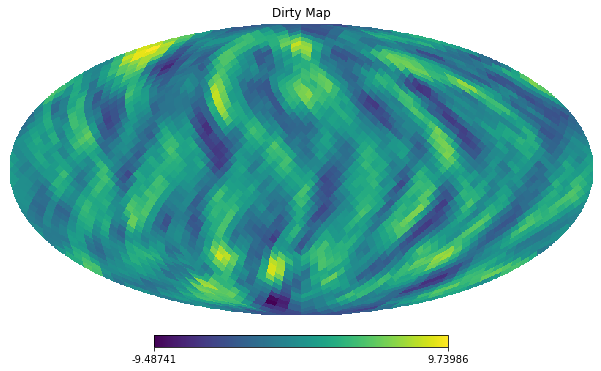

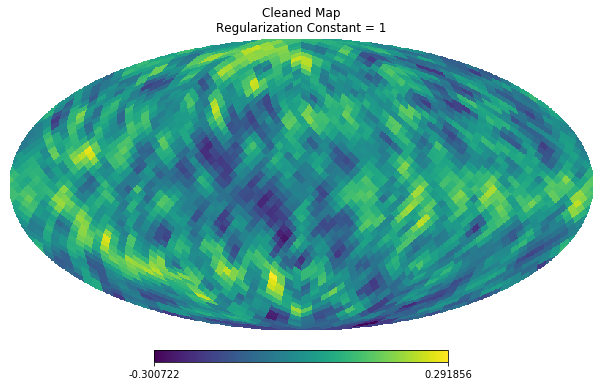

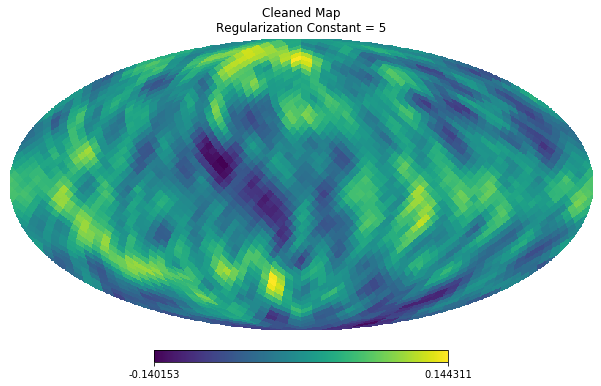

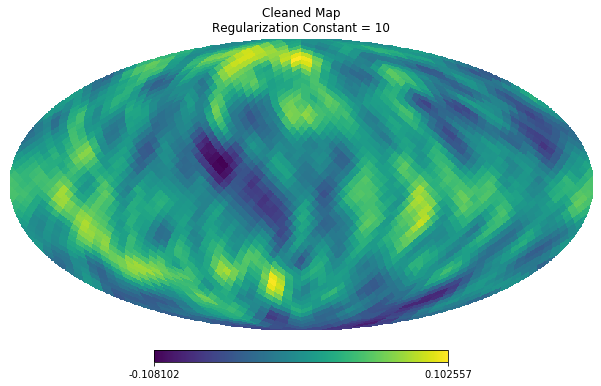

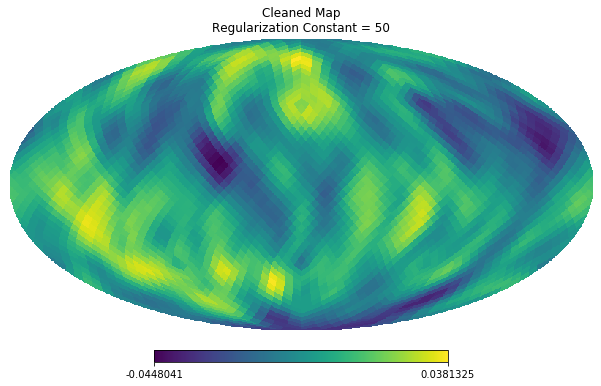

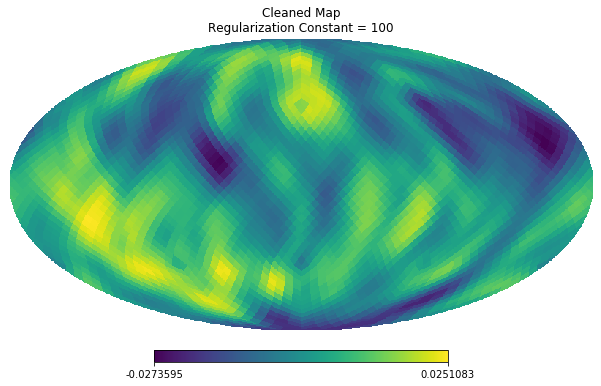

In [28]:
l_list = [1, 5, 10, 50, 100]
hp.mollview(map_dirty_n, title = 'Dirty Map')

for l in l_list:
    
    clean_map = deconvolution(map_dirty_n, fisher_n, reg_strength = l, hessian = H)
    hp.mollview(clean_map[0], title = 'Cleaned Map\nRegularization Constant = {}'.format(l))
    plt.show()

#### __NARROWBAND CLEAN MAP:__

- Import narrowband dirty maps and Fisher matrix from src/NPY_files folder.
- Normalise each narrowband map and matrix.

In [29]:
# Frequency of the Narrowband Map to observe:
freq = [40, 120, 500, 1000]

In [30]:
path_new = path + 'NPY_files/narrowBand/'
fisher_NB = []
map_dirty_NB = []
for f in freq:
    fisher_filename = '_'.join(['Fisher', str(f), str(f)]) + 'Hz.npy'
    map_dirty_filename = '_'.join(['Dirty_Map', str(f), str(f)]) + 'Hz.npy'
    
    # LOAD FILE
    fisher_f = np.load(path_new + fisher_filename, allow_pickle = True)
    map_dirty_f = np.load(path_new + map_dirty_filename, allow_pickle = True)
    
    # NORMALISE
    fisher_f = normalise(np.real(fisher_f))
    map_dirty_f = normalise(np.squeeze(map_dirty_f))
    
    fisher_NB.append(fisher_f)
    map_dirty_NB.append(map_dirty_f)

Clean Maps:

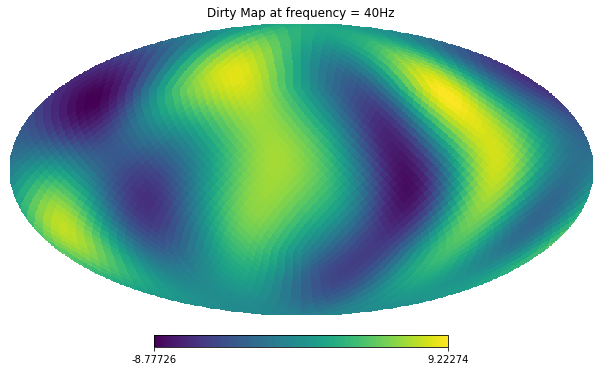

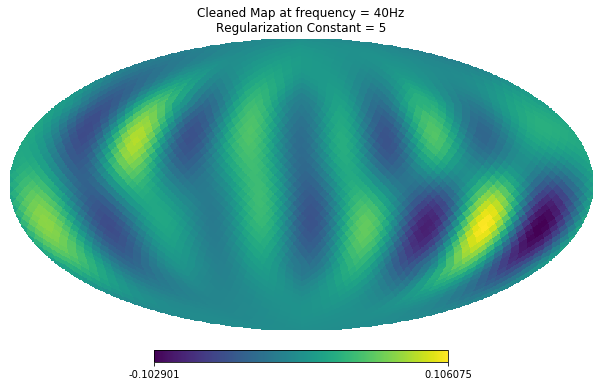

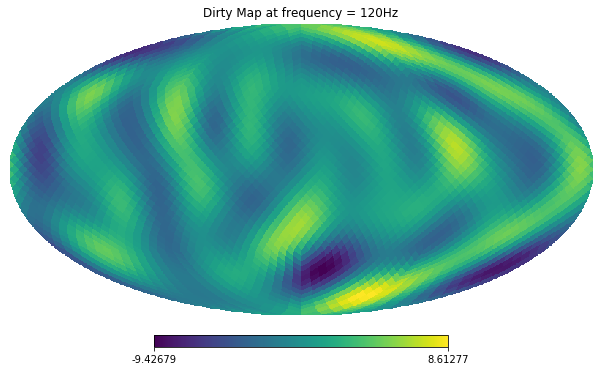

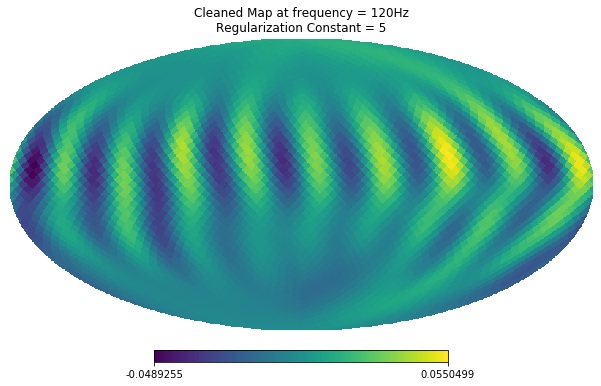

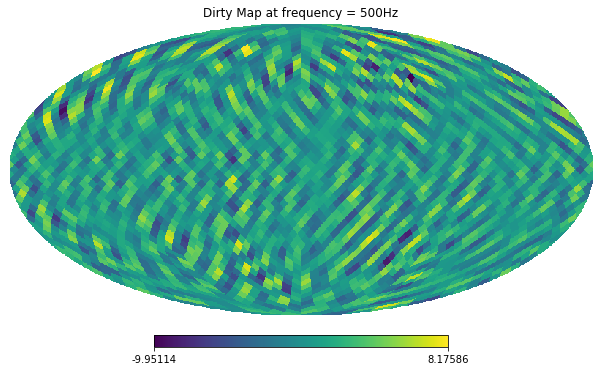

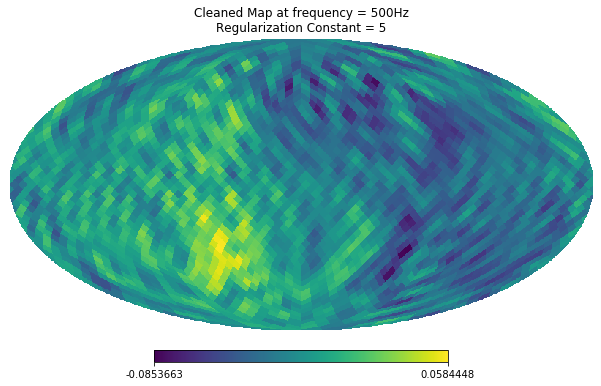

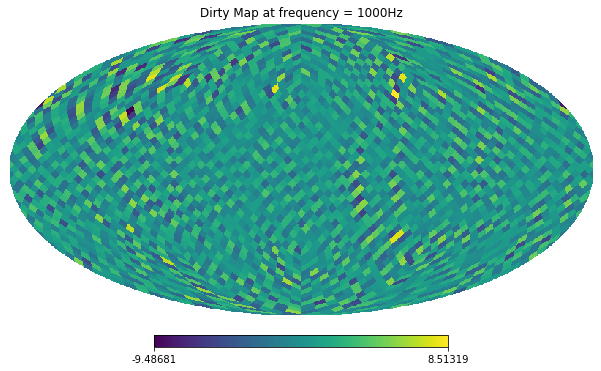

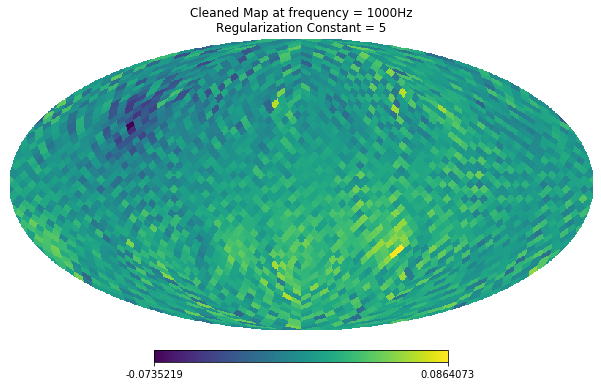

In [31]:
l = 5
for j, f in enumerate(freq):
    hp.mollview(np.real(map_dirty_NB[j]), title = 'Dirty Map at frequency = {}Hz'.format(f))
    clean_map_f = deconvolution(map_dirty_NB[j], fisher_NB[j], reg_strength = l, hessian = H)
    hp.mollview(clean_map_f[0], title = 'Cleaned Map at frequency = {}Hz\nRegularization Constant = {}'.format(f, l))
    plt.show()

#### __NarrowBand analysis for individual frequency__

In [32]:
# Frequency of the Narrowband Map to observe:
freq = 1000

In [33]:
path_new = path + 'NPY_files/narrowBand/'
fisher_filename = '_'.join(['Fisher', str(freq), str(freq)]) + 'Hz.npy'
map_dirty_filename = '_'.join(['Dirty_Map', str(freq), str(freq)]) + 'Hz.npy'

# LOAD FILE
fisher_f = np.load(path_new + fisher_filename, allow_pickle = True)
map_dirty_f = np.load(path_new + map_dirty_filename, allow_pickle = True)

# NORMALISE
fisher_f = normalise(np.real(fisher_f))
map_dirty_f = normalise(np.squeeze(map_dirty_f))

Clean Map:

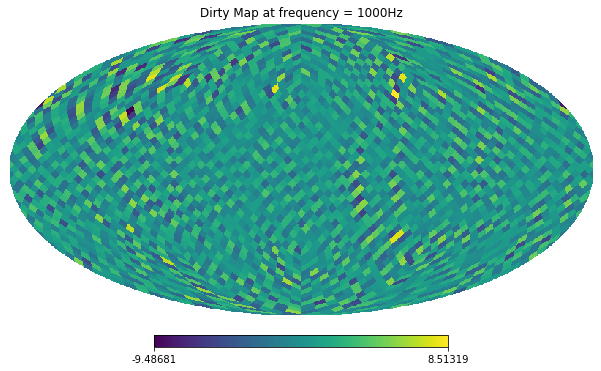

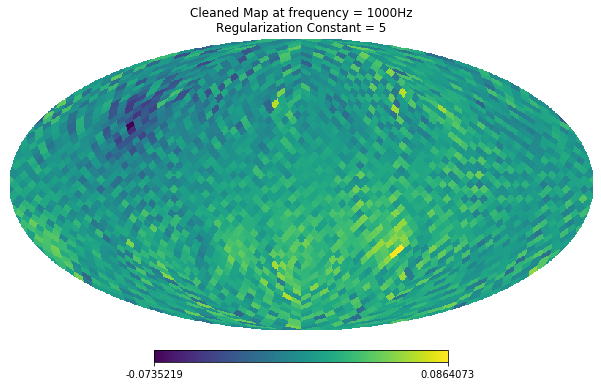

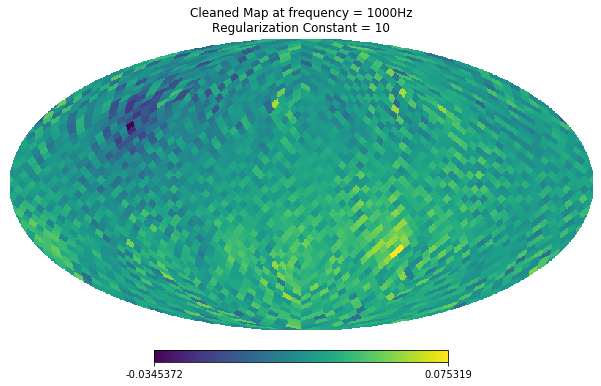

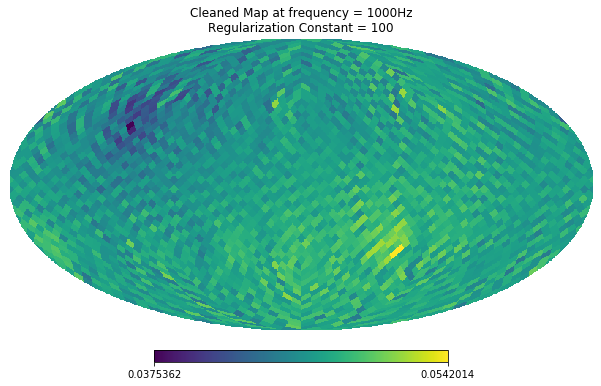

In [34]:
reg_const = [5, 10, 100]
hp.mollview(np.real(map_dirty_f), title = 'Dirty Map at frequency = {}Hz'.format(freq))

for l in reg_const:
    clean_map_f = deconvolution(map_dirty_f, fisher_f, reg_strength = l, hessian = H)
    hp.mollview(clean_map_f[0], title = 'Cleaned Map at frequency = {}Hz\nRegularization Constant = {}'.format(freq, l))
    plt.show()